In [ ]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
from nltk import bigrams
import os
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import nltk
from nltk.corpus import stopwords
import emoji

# Setup
nltk.download('stopwords', quiet=True)

True

load dataset 

In [25]:
# Charger le dataset
dataset = load_dataset("7Xan7der7/us_airline_sentiment")

# verife shap
dataset.shape

{'train': (14640, 13)}

to pandas

In [26]:
df = dataset["train"].to_pandas()
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,None,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,None,2/24/2015 11:35,None,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,None,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,None,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,None,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,None,2/24/2015 11:14,None,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,5.695880e+17,positive,0.3487,None,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,None,2/22/2015 12:01,None,None
14636,5.695870e+17,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,None,2/22/2015 11:59,Texas,None
14637,5.695870e+17,neutral,1.0000,None,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,None,2/22/2015 11:59,"Nigeria,lagos",None
14638,5.695870e+17,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",None,2/22/2015 11:59,New Jersey,Eastern Time (US & Canada)


---
## EDA

Analyse exploratoire des données (EDA) : Étudier la répartition des classes, les distributions et les statistiques principales.

### Overview

In [27]:
# df.info()

In [28]:
df.dtypes

tweet_id                        float64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
name                             object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [29]:
df.columns.tolist()

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'name',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [30]:
df.shape

(14640, 13)

###  Dataset Structure - 13 Columns - +14k rows

-  **tweet_id** - Unique identifier
- **airline_sentiment** - Target variable (negative/neutral/positive)
- **airline_sentiment_confidence** - Confidence score for sentiment
- **negativereason** - Reason for negative sentiment (when applicable)
- **negativereason_confidence** - Confidence for the negative reason
- **airline** - Which airline 
- **name** - Twitter username
- **retweet_count** - Number of retweets
- **text** - The actual tweet content (main feature)
- **tweet_coord** - Geographic coordinates 
- **tweet_created** - Timestamp
- **tweet_location** - User location
- **user_timezone** - User's timezone


**Task type :** Multi-class → positive / neutral / negative

**Evaluation metric:** Imbalanced data → F1-score



---

### 1 - missing values


In [31]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
name                                0
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [32]:
(df['text'].str.strip() == "").sum()

np.int64(0)

### 2- DUPLICATES ANALYSIS

In [33]:
df.duplicated(subset=['text']).sum()


np.int64(213)

In [34]:
#  Detect Duplicates# Check for duplicate tweets
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Duplicate tweet text: {df['text'].duplicated().sum()}")

# Show some duplicates
duplicates = df[df['text'].duplicated(keep=False)].sort_values(by="text")

duplicates

Duplicate rows: 39
Duplicate tweet text: 213


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12067,5.703010e+17,negative,1.0000,Customer Service Issue,1.0000,American,skgiffard,0,.@AmericanAir can you connect me to a person w...,None,2/24/2015 11:17,"Boston, MA",Eastern Time (US & Canada)
11906,5.703010e+17,negative,0.6703,Customer Service Issue,0.6703,American,skgiffard,0,.@AmericanAir can you connect me to a person w...,None,2/24/2015 11:17,"Boston, MA",Eastern Time (US & Canada)
11902,5.703030e+17,neutral,1.0000,None,NaN,American,trentgillaspie,0,.@AmericanAir just disappointed with the Fligh...,None,2/24/2015 11:24,"Austin, but often Denver",Mountain Time (US & Canada)
12063,5.703030e+17,neutral,1.0000,None,NaN,American,trentgillaspie,0,.@AmericanAir just disappointed with the Fligh...,None,2/24/2015 11:24,"Austin, but often Denver",Mountain Time (US & Canada)
11946,5.702880e+17,negative,1.0000,Lost Luggage,0.6593,American,jacquelinewins6,0,@AmericanAir\n Your response could have made a...,None,2/24/2015 10:24,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12002,5.702720e+17,positive,1.0000,None,NaN,American,superyan,0,Just got off the phone @AmericanAir customer s...,None,2/24/2015 9:19,None,None
11922,5.702970e+17,negative,1.0000,Customer Service Issue,0.3780,American,Andrew_Wasila,0,“@AmericanAir: @Andrew_Wasila We're sorry you ...,None,2/24/2015 11:01,None,Quito
12083,5.702970e+17,negative,0.6831,Can't Tell,0.6831,American,Andrew_Wasila,0,“@AmericanAir: @Andrew_Wasila We're sorry you ...,None,2/24/2015 11:01,None,Quito
12012,5.702700e+17,positive,0.6629,None,NaN,American,marypoppings,0,“@AmericanAir: We hope you enjoy the #WinterWe...,None,2/24/2015 9:12,New York/Nicaragua/Miami Beach,Eastern Time (US & Canada)


In [35]:
# Remove duplicates 
df = df.drop_duplicates(subset=['text'], keep='first')

print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Duplicate tweet text: {df['text'].duplicated().sum()}")

Duplicate rows: 0
Duplicate tweet text: 0


### 3- Class distribution

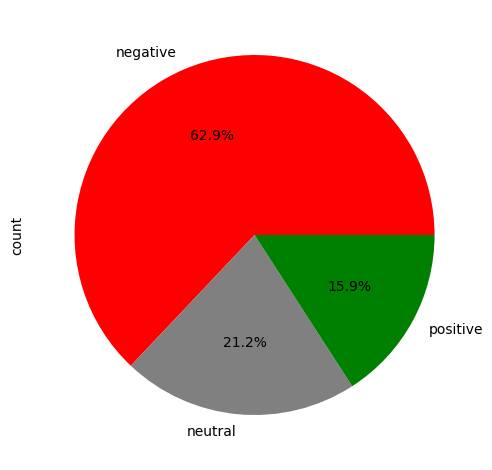

airline_sentiment
negative    9080
neutral     3057
positive    2290
Name: count, dtype: int64

In [36]:
# Pie chart
df['airline_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                             colors=['red', 'gray', 'green'])

plt.tight_layout()
plt.show()
df['airline_sentiment'].value_counts()


---

### Airline Distribution

In [37]:
### Airline Distribution
df['airline'].value_counts()


airline
United            3805
US Airways        2906
American          2594
Southwest         2408
Delta             2211
Virgin America     503
Name: count, dtype: int64

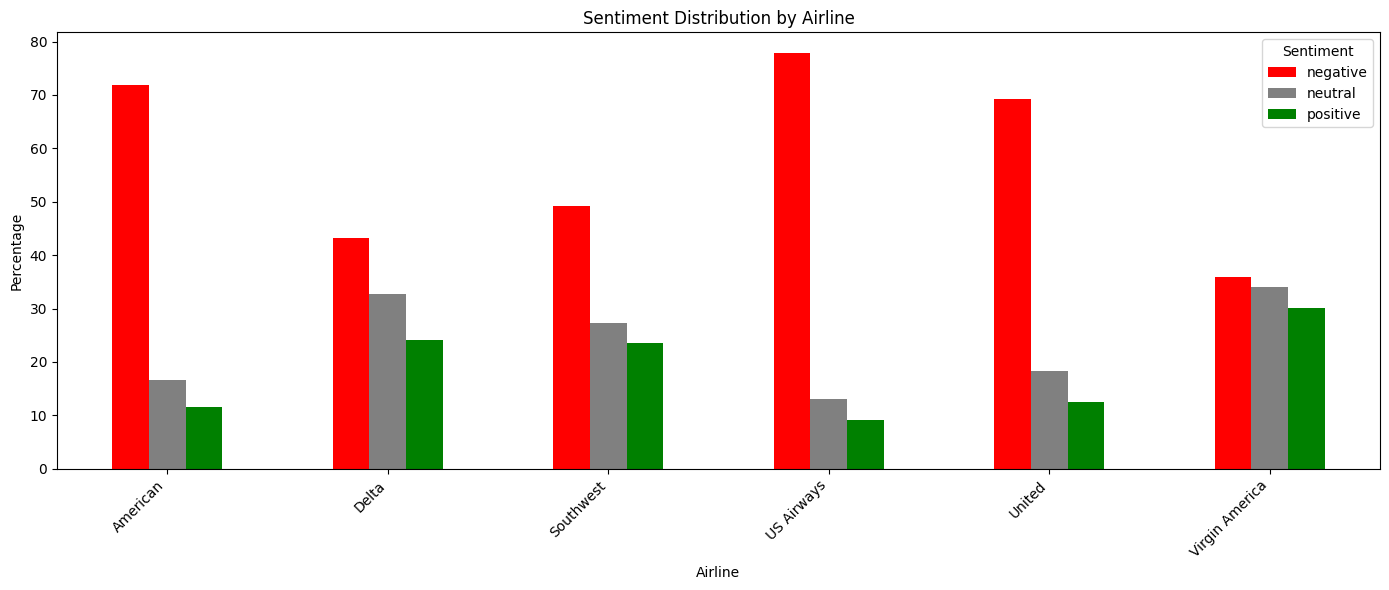


Sentiment Distribution by Airline (%):


airline_sentiment,negative,neutral,positive
airline,,,
American,71.86,16.62,11.53
Delta,43.19,32.70,24.11
Southwest,49.21,27.33,23.46
US Airways,77.84,13.08,9.08
United,69.20,18.24,12.56
Virgin America,35.98,34.00,30.02


In [38]:
airline_sentiment = pd.crosstab(df['airline'], df['airline_sentiment'], normalize='index') * 100



# Visualize
airline_sentiment.plot(kind='bar', stacked=False, figsize=(14, 6), 
                       color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution by Airline')
plt.ylabel('Percentage') 
plt.xlabel('Airline')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Sentiment by airline
print("\nSentiment Distribution by Airline (%):")
airline_sentiment.round(2)

### Text statistics

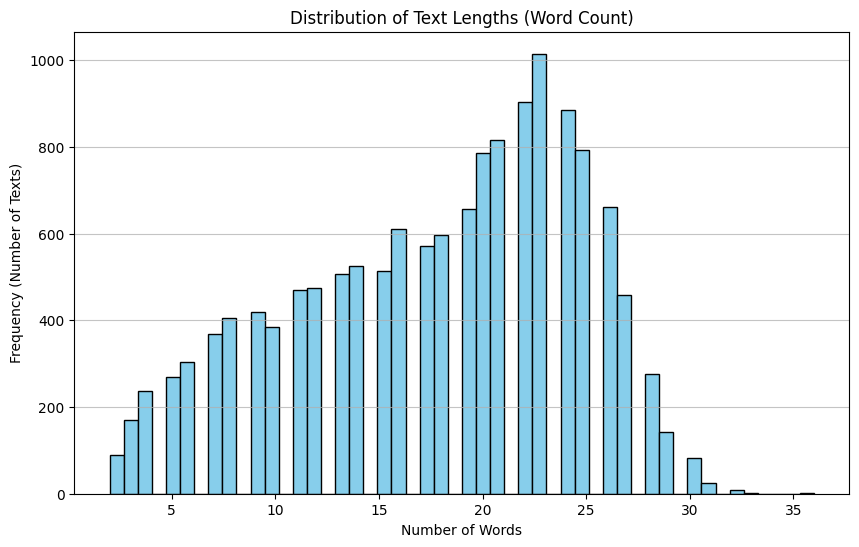

In [39]:
# text distribution

texts = df["text"]

text_lengths = [len(text.split()) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency (Number of Texts)')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [40]:
tdf = df.copy()

tdf['text_length'] = tdf['text'].str.len()
tdf['word_count'] = tdf['text'].str.split().str.len()
tdf['char_count'] = tdf['text'].str.len()

tdf[['text_length', 'word_count','char_count']].describe()


,text_length,word_count,char_count
count,14427.000000,14427.000000,14427.000000
mean,104.161711,17.717959,104.161711
std,35.948353,6.828966,35.948353
min,12.000000,2.000000,12.000000
25%,77.000000,13.000000,77.000000
50%,115.000000,19.000000,115.000000
75%,136.000000,23.000000,136.000000
max,186.000000,36.000000,186.000000


### Special caracter and emojis analytics

In [41]:

analytic_df = df.copy()


def contains_emoji_or_smiley(text):
    text_str = str(text)
    
    # Check for Unicode emojis using emoji library
    has_unicode_emoji = any(char in emoji.EMOJI_DATA for char in text_str)
    
    # Check for text smileys using regex
    # Using raw string to avoid the warning
    smiley_pattern = r':-\)|:\)|:-D|:D|:\(|:-\(|:P|:-P|;\)|;-\)|:\*|:-\*'
    has_text_smiley = bool(re.search(smiley_pattern, text_str))
    
    return has_unicode_emoji or has_text_smiley

analytic_df['has_emoji'] = analytic_df['text'].apply(contains_emoji_or_smiley)




emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]|:[)]|:D|:\(|:-\)|:\)|:-D|:-\(|:P|:-P|:O|:-O'


analytic_df['has_mention'] = analytic_df['text'].str.contains('@', regex=False)
analytic_df['has_hashtag'] = analytic_df['text'].str.contains('#', regex=False)
analytic_df['has_url'] = analytic_df['text'].str.contains('http', case=False, regex=True)
analytic_df['has_emoji'] = analytic_df['text'].str.contains(emoji_pattern, regex=True)
# analytic_df['has_emoji'] = analytic_df['text'].str.contains(':-\)|:\)|:-D|:\(|:-\(', regex=True)

print("\nSpecial Content Analysis:")
print(f"Tweets with mentions (@): {analytic_df['has_mention'].sum()} ({analytic_df['has_mention'].mean()*100:.1f}%)")
print(f"Tweets with hashtags (#): {analytic_df['has_hashtag'].sum()} ({analytic_df['has_hashtag'].mean()*100:.1f}%)")
print(f"Tweets with URLs: {analytic_df['has_url'].sum()} ({analytic_df['has_url'].mean()*100:.1f}%)")
print(f"Tweets with emojis: {analytic_df['has_emoji'].sum()} ({analytic_df['has_emoji'].mean()*100:.1f}%)")



Special Content Analysis:
Tweets with mentions (@): 14427 (100.0%)
Tweets with hashtags (#): 2463 (17.1%)
Tweets with URLs: 1163 (8.1%)
Tweets with emojis: 707 (4.9%)


### Agrégation des données (Resons analytics):


In [42]:

stop_words = set(stopwords.words('english'))


def clean_and_extract_words(text):
    """Extract words, removing mentions, URLs, special characters, and stopwords"""
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'&\w+;', '', text)  # Remove HTML entities
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.lower().split()
    
    # Remove stopwords and short words
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return words


all_words = []
for text in df['text']:
    all_words.extend(clean_and_extract_words(text))




In [ ]:
# Top words overall
word_freq = Counter(all_words).most_common(20)
print("\nTop 20 Most Common Words")
for word, count in word_freq:
    print(f"  {word}: {count}")


Top 20 Most Common Words (Stopwords Removed):
  flight: 3824
  get: 1326
  cancelled: 1034
  thanks: 1030
  service: 948
  help: 846
  time: 762
  customer: 739
  hours: 661
  flights: 641
  hold: 631
  plane: 616
  thank: 575
  cant: 573
  still: 567
  one: 555
  please: 552
  need: 549
  would: 543
  delayed: 522


In [ ]:
all_bigrams = list(bigrams(all_words))
bigram_freq = Counter(all_bigrams).most_common(10)
print("\nTop 10 Most Common Bigrams:")
for bigram, count in bigram_freq:
    print(f"  {' '.join(bigram)}: {count}")


Top 10 Most Common Bigrams:
  customer service: 551
  cancelled flightled: 488
  late flight: 242
  cancelled flighted: 213
  flight cancelled: 200
  late flightr: 154
  fleets fleek: 145
  booking problems: 143
  cancelled flight: 139
  cant get: 119


In [45]:
# BIGRAMS BY SENTIMENT

for sentiment in ['negative', 'neutral', 'positive']:
    # Extract words for this sentiment
    sentiment_texts = df[df['airline_sentiment'] == sentiment]['text']
    sentiment_words = []
    for text in sentiment_texts:
        sentiment_words.extend(clean_and_extract_words(text))
    
    # Generate bigrams
    sentiment_bigrams = list(bigrams(sentiment_words))
    bigram_freq = Counter(sentiment_bigrams).most_common(10)
    
    print(f"\n{sentiment.upper()}:")
    for bigram, count in bigram_freq:
        print(f"  {' '.join(bigram)}: {count}")



NEGATIVE:
  customer service: 440
  cancelled flightled: 430
  late flight: 216
  cancelled flighted: 191
  flight cancelled: 189
  late flightr: 142
  cancelled flight: 120
  cant get: 106
  call back: 99
  booking problems: 97

NEUTRAL:
  fleets fleek: 102
  cancelled flightled: 46
  booking problems: 34
  fleek fleets: 29
  flight booking: 27
  please help: 23
  passengers wall: 21
  customer service: 20
  would love: 20
  wall street: 17

POSITIVE:
  customer service: 91
  thank much: 37
  great flight: 28
  thanks much: 27
  thank thanks: 23
  great job: 22
  thanks help: 21
  flight attendant: 20
  cant wait: 20
  thanks thanks: 20



Taux de satisfaction par compagnie (% positive + neutral):
airline
Virgin America    64.02
Delta             56.81
Southwest         50.79
United            30.80
American          28.14
US Airways        22.16
dtype: float64


C:\Users\alibo\AppData\Local\Temp\ipykernel_61784\3686668733.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  satisfaction_rate = df.groupby('airline').apply(


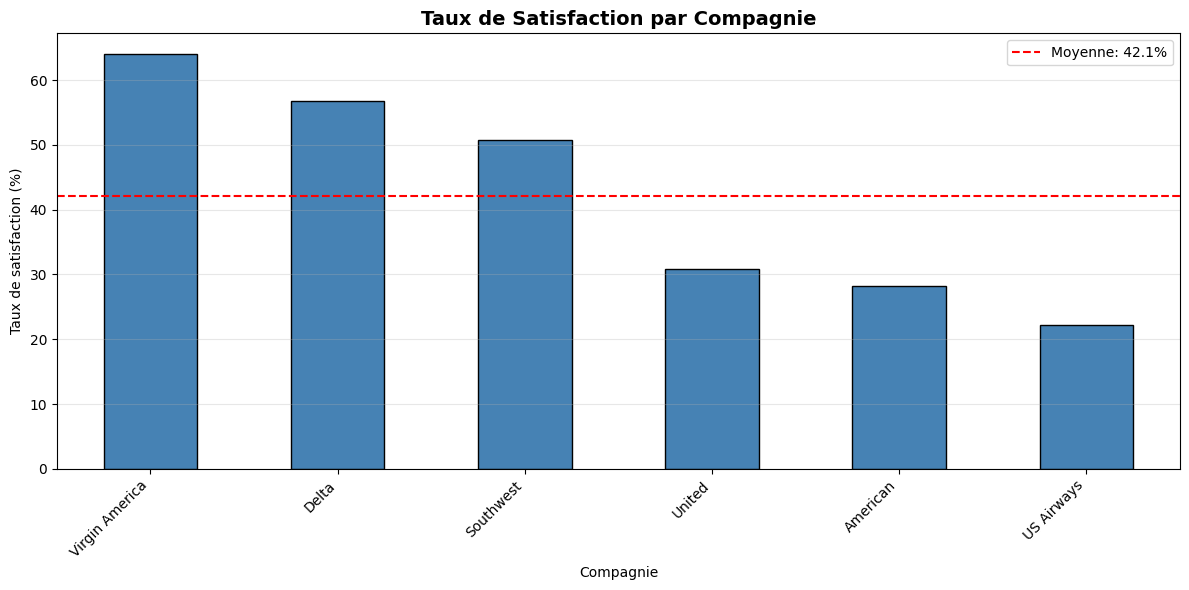

In [46]:
# taux de satisfaction par compagnie
satisfaction_rate = df.groupby('airline').apply(
    lambda x: ((x['airline_sentiment'] == 'positive').sum() + 
               (x['airline_sentiment'] == 'neutral').sum()) / len(x) * 100
).sort_values(ascending=False)

print("\nTaux de satisfaction par compagnie (% positive + neutral):")
print(satisfaction_rate.round(2))

# Visualize
plt.figure(figsize=(12, 6))
satisfaction_rate.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Taux de Satisfaction par Compagnie', fontsize=14, fontweight='bold')
plt.ylabel('Taux de satisfaction (%)')
plt.xlabel('Compagnie')
plt.axhline(y=satisfaction_rate.mean(), color='red', linestyle='--', 
            label=f'Moyenne: {satisfaction_rate.mean():.1f}%')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Total tweets négatifs: 9080
Tweets avec raison spécifiée: 9080
Tweets sans raison: 0

Principales causes de tweets négatifs:
negativereason
Customer Service Issue         2883
Late Flight                    1650
Can't Tell                     1176
Cancelled Flight                829
Lost Luggage                    719
Bad Flight                      575
Flight Booking Problems         523
Flight Attendant Complaints     475
longlines                       177
Damaged Luggage                  73
Name: count, dtype: int64


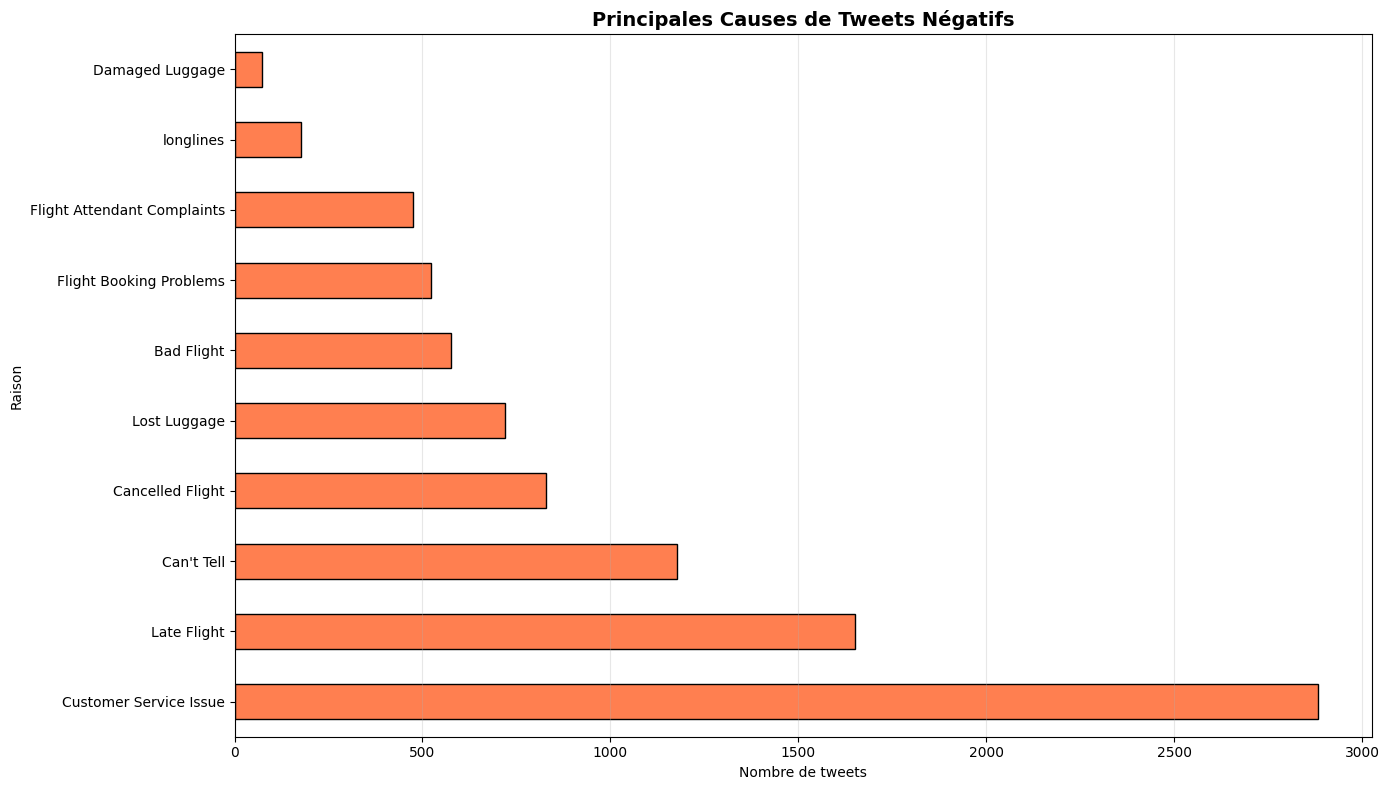


Top 3 raisons négatives par compagnie:

American:
  - Customer Service Issue: 743
  - Late Flight: 234
  - Cancelled Flight: 228

Delta:
  - Late Flight: 269
  - Customer Service Issue: 199
  - Can't Tell: 186

Southwest:
  - Customer Service Issue: 390
  - Cancelled Flight: 162
  - Can't Tell: 159

US Airways:
  - Customer Service Issue: 810
  - Late Flight: 453
  - Can't Tell: 246

United:
  - Customer Service Issue: 681
  - Late Flight: 525
  - Can't Tell: 379

Virgin America:
  - Customer Service Issue: 60
  - Flight Booking Problems: 28
  - Can't Tell: 22


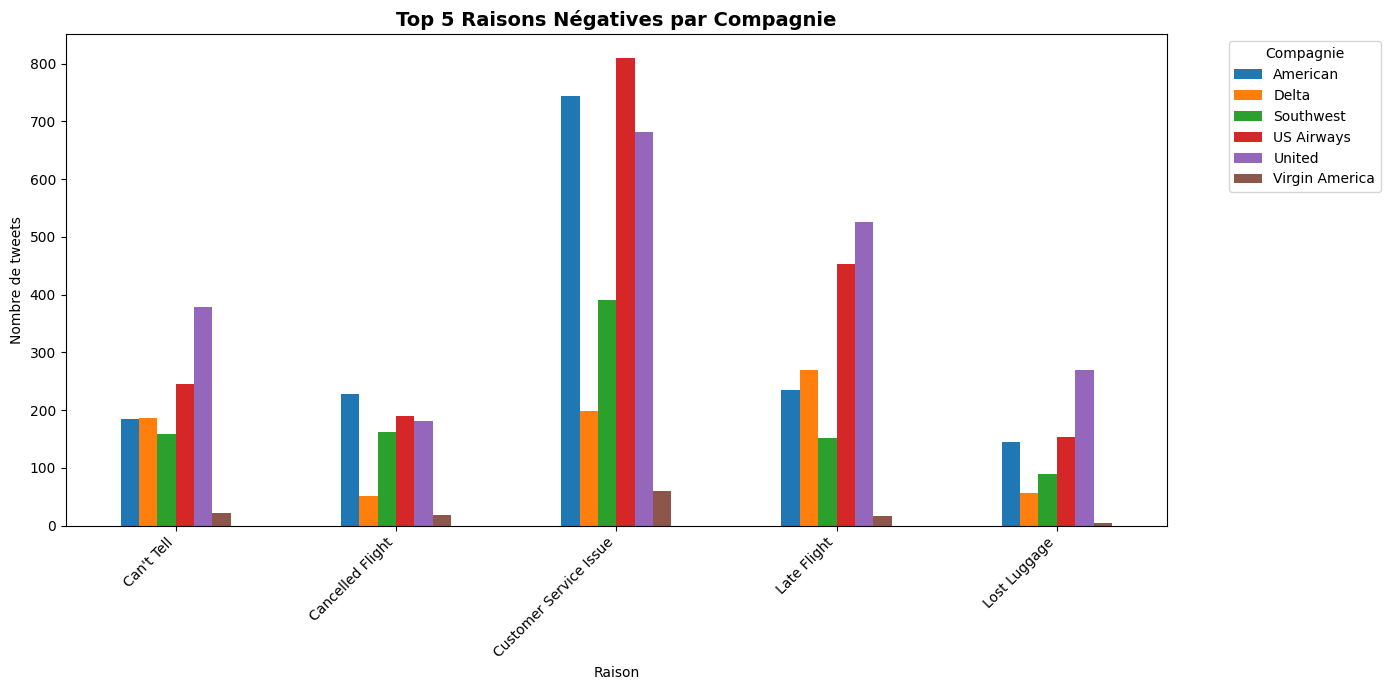

In [47]:
#  principales causes de tweets négatifs.

# Analyze negative reasons
negative_df = df[df['airline_sentiment'] == 'negative'].copy()

print(f"\nTotal tweets négatifs: {len(negative_df)}")
print(f"Tweets avec raison spécifiée: {negative_df['negativereason'].notna().sum()}")
print(f"Tweets sans raison: {negative_df['negativereason'].isna().sum()}")

# Top negative reasons
negative_reasons = negative_df['negativereason'].value_counts()
print("\nPrincipales causes de tweets négatifs:")
print(negative_reasons)

# Visualize
plt.figure(figsize=(14, 8))
negative_reasons.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Principales Causes de Tweets Négatifs', fontsize=14, fontweight='bold')
plt.xlabel('Nombre de tweets')
plt.ylabel('Raison')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


negative_by_airline = pd.crosstab(
    negative_df['airline'], 
    negative_df['negativereason']
)

print("\nTop 3 raisons négatives par compagnie:")
for airline in negative_by_airline.index:
    top_reasons = negative_by_airline.loc[airline].sort_values(ascending=False).head(3)
    print(f"\n{airline}:")
    for reason, count in top_reasons.items():
        if count > 0:
            print(f"  - {reason}: {count}")

# Visualize top reasons per airline
top_reasons = negative_reasons.head(5).index
negative_filtered = negative_df[negative_df['negativereason'].isin(top_reasons)]
reason_airline = pd.crosstab(negative_filtered['negativereason'], 
                              negative_filtered['airline'])

reason_airline.plot(kind='bar', figsize=(14, 7), stacked=False)
plt.title('Top 5 Raisons Négatives par Compagnie', fontsize=14, fontweight='bold')
plt.xlabel('Raison')
plt.ylabel('Nombre de tweets')
plt.legend(title='Compagnie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

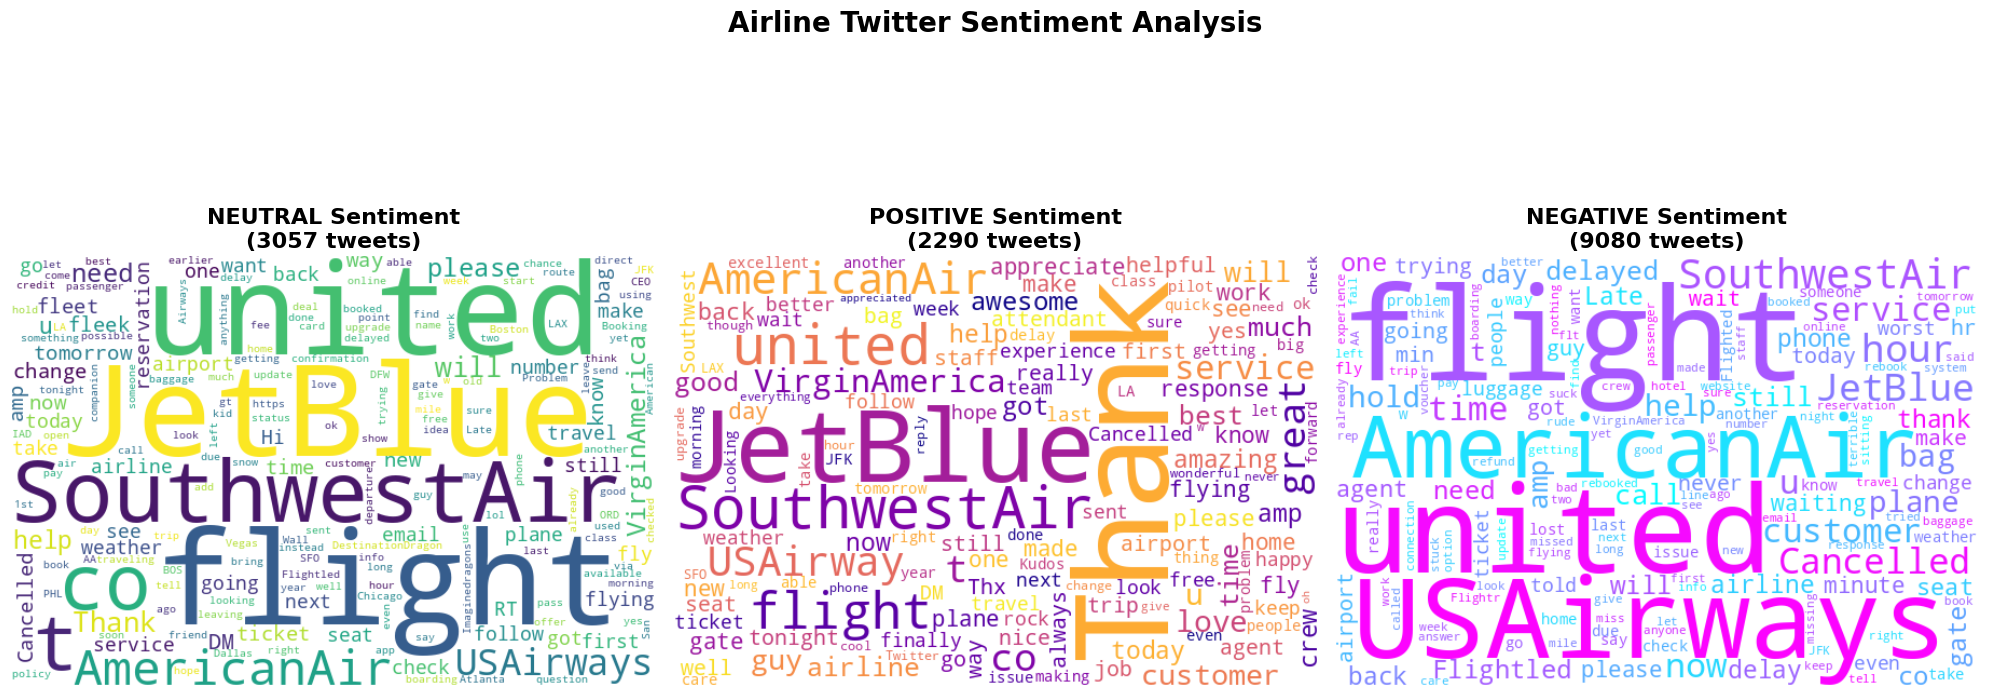

In [48]:


unique_labels = df["airline_sentiment"].unique()

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, label in enumerate(unique_labels):
    texts_for_label = df[df['airline_sentiment'] == label]['text']
    combined_text = ' '.join(texts_for_label)
    
    wordcloud = WordCloud(
        width=600, 
        height=400,
        background_color='white',
        colormap=['viridis', 'plasma', 'cool'][idx],
        stopwords=STOPWORDS,
        collocations=False,  # Don't include bi-grams
        min_font_size=10,
        max_font_size=120
    ).generate(combined_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(
        f'{label.upper()} Sentiment\n({len(texts_for_label)} tweets)', 
        fontsize=16, 
        fontweight='bold'
    )
    axes[idx].axis('off')
    axes[idx].grid(False)

plt.suptitle('Airline Twitter Sentiment Analysis', fontsize=20, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

---

save data

In [51]:
# Define columns to remove
columns_to_remove = [
    'user_timezone', 
    'tweet_id', 
    'airline_sentiment_confidence', 
    'negativereason_confidence', 
    'tweet_location', 
    'tweet_coord', 
    'retweet_count', 
    'name'
]

# Remove columns (if they exist)
existing_columns = [col for col in columns_to_remove if col in df.columns]
df_clean = df.drop(columns=existing_columns).copy()


# save raw data witout duplicates values
os.makedirs("../data/raw", exist_ok=True)
df_clean.to_csv("../data/raw/data.csv", index=False)
df.to_csv("../data/raw/raw-data.csv", index=False)



print(f"Removed columns: {existing_columns}")
print(f"Remaining columns: {list(df_clean.columns)}")
print(f"Dataset saved")

Removed columns: ['user_timezone', 'tweet_id', 'airline_sentiment_confidence', 'negativereason_confidence', 'tweet_location', 'tweet_coord', 'retweet_count', 'name']
Remaining columns: ['airline_sentiment', 'negativereason', 'airline', 'text', 'tweet_created']
Dataset saved


In [50]:
df_clean

,airline_sentiment,negativereason,airline,text,tweet_created
0,neutral,None,Virgin America,@VirginAmerica What @dhepburn said.,2/24/2015 11:35
1,positive,None,Virgin America,@VirginAmerica plus you've added commercials t...,2/24/2015 11:15
2,neutral,None,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2/24/2015 11:15
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,2/24/2015 11:15
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,2/24/2015 11:14
...,...,...,...,...,...
14635,positive,None,American,@AmericanAir thank you we got on a different f...,2/22/2015 12:01
14636,negative,Customer Service Issue,American,@AmericanAir leaving over 20 minutes Late Flig...,2/22/2015 11:59
14637,neutral,None,American,@AmericanAir Please bring American Airlines to...,2/22/2015 11:59
14638,negative,Customer Service Issue,American,"@AmericanAir you have my money, you change my ...",2/22/2015 11:59
